In [52]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import random

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import torchvision.transforms.functional as F

from file_manipulations import getSortedFramePaths
from vae_conv import VariationalAutoencoder, Encoder, Decoder

In [53]:
device = torch.device("cuda")

In [54]:
vae = VariationalAutoencoder().to(device)
vae.load_state_dict(torch.load('vae_conv.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (conv_trans_1): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=256, out_features=512, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [55]:
# seq_len_x = 15
batch_size = 32
image_size = 64

In [75]:
image_path = "/media/hitsuji/Back/Dance Data/Skeleton/Basic/"
composed_transform = torchvision.transforms.Compose([transforms.Resize(image_size), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms):
        self.transforms = transforms
        self.image_path = image_path
        self.seq_len_x = 15
        self.seq_len_y = 20
        self.image_names = getSortedFramePaths(self.image_path, ['gLH'])
    def __len__ (self):
        return len(self.image_names) - self.seq_len_x - self.seq_len_y
    def __getitem__(self, idx):
        image_locations = self.image_names[idx:idx+self.seq_len_x+self.seq_len_y]
        images = torch.empty(self.seq_len_x+self.seq_len_y, 256)
        i = 0
        with torch.no_grad():
            for image_location in image_locations:
                x = (self.transforms(Image.open(image_location)) > 0.5).float().view(1, 1, 64, 64)
                images[i] = vae.encoder(x.to(device))[0]
                i += 1
        

        return images[0:self.seq_len_x], images[self.seq_len_x:self.seq_len_x+self.seq_len_y]
    
frame_dataset = DanceFrameDataset(image_path, composed_transform)
frame_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [76]:
idx = 0

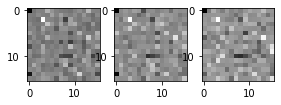

In [77]:
frames_x, frames_y = next(iter(frame_loader))
frames_x_dec = frames_y.to(device)
frames_x_dec = vae.decoder(frames_x_dec[idx])

for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(frames_y[0][i].view(16, 16), cmap="gray")

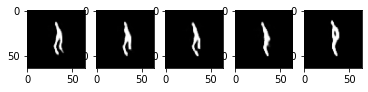

In [79]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(frames_x_dec[i].detach().cpu().view(64, 64), cmap="gray")

In [80]:
class Encoder(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        
    def forward(self, x):
        # (seq_len, batch_size)
        
        outputs, (hidden, cell) = self.rnn(x)
        
        
        return hidden, cell
        

In [81]:
class Decoder(nn.Module):
    def __init__ (self, num_features, hidden_size, num_layers, p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout(p)
        self.rnn = nn.LSTM(num_features, hidden_size, num_layers, dropout=p, batch_first=True)
        self.fc =  nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, hidden, cell):
        # x -> we want (1, N) -. one word at a time
        x = x.unsqueeze(1)
        
        predictions, (hidden, cell) = self.rnn(x, (hidden, cell))

        predictions = self.fc(predictions)
#         predictions = predictions.squeeze(0)
        return predictions, hidden, cell

In [82]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio):
        batch_size = source.shape[0] #hmm 0
        target_len = target.shape[1] # hmm 1
        
        
        hidden, cell = self.encoder(source)
        
        x = target[:, 0, :]
        
        for t in range(target_len):
            output, hidden, cell= self.decoder(x, hidden, cell)
            
            if 'outputs' in locals():
                outputs = torch.cat((outputs, output), dim=1)
            else:
                outputs = output
            
#             x = target[:, t, :] if random.random() < teacher_force_ratio else output

            x = target[:, t, :]
        return outputs

In [83]:
num_epochs = 20
learning_rate = 0.001

num_features = 256
hidden_size = 256
num_layers = 2
dropout = 0.5

loss_hist = []

In [84]:
encoder_net = Encoder(num_features, hidden_size, num_layers, dropout).to(device)
decoder_net = Decoder(num_features, hidden_size, num_layers, dropout).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [85]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [87]:
for epoch in range(num_epochs):
    for idx, (source, target) in enumerate(frame_loader):
        optimizer.zero_grad()
        
        source, target = source.to(device), target.to(device)

        output = model(source, target, 0.5)
        
        loss1 = criterion(output[:, 0, :], target[:, 0, :])
        
        loss2 = criterion(output[:, -1, :], target[:, -1, :])
        
        loss = loss1 + loss2
        
        loss_hist.append(loss.item())
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
    
    
        if idx % 100 == 0:
            print(f'Epoch: {epoch} / {num_epochs} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

Epoch: 0 / 20 Batch:: 0/700 Loss: 0.47512808442115784
Epoch: 0 / 20 Batch:: 100/700 Loss: 0.691209614276886
Epoch: 0 / 20 Batch:: 200/700 Loss: 0.392522931098938
Epoch: 0 / 20 Batch:: 300/700 Loss: 0.3543241620063782
Epoch: 0 / 20 Batch:: 400/700 Loss: 0.26636433601379395
Epoch: 0 / 20 Batch:: 500/700 Loss: 0.4429841935634613
Epoch: 0 / 20 Batch:: 600/700 Loss: 0.32758116722106934
Epoch: 1 / 20 Batch:: 0/700 Loss: 0.2804206907749176
Epoch: 1 / 20 Batch:: 100/700 Loss: 0.4439447522163391
Epoch: 1 / 20 Batch:: 200/700 Loss: 0.2603890299797058
Epoch: 1 / 20 Batch:: 300/700 Loss: 0.2732386589050293
Epoch: 1 / 20 Batch:: 400/700 Loss: 0.22311696410179138
Epoch: 1 / 20 Batch:: 500/700 Loss: 0.3580569922924042
Epoch: 1 / 20 Batch:: 600/700 Loss: 0.30200639367103577
Epoch: 2 / 20 Batch:: 0/700 Loss: 0.25319817662239075
Epoch: 2 / 20 Batch:: 100/700 Loss: 0.41591525077819824
Epoch: 2 / 20 Batch:: 200/700 Loss: 0.24391373991966248
Epoch: 2 / 20 Batch:: 300/700 Loss: 0.2577233612537384
Epoch: 2 /

KeyboardInterrupt: 

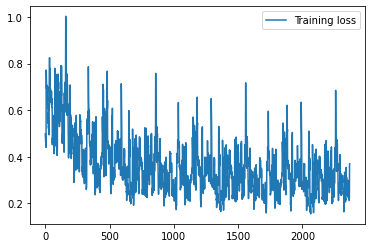

In [88]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

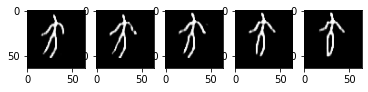

In [34]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(target[15])).detach().cpu()
    for i in range(seq_len):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

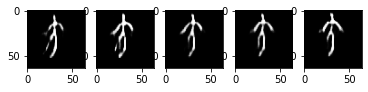

In [35]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(output[15])).detach().cpu()
    for i in range(seq_len):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")

In [ ]:
# class RNNEncoder(nn.Module):
#     def __init__(self, rnn_num_layers=1, input_feature_len=256, sequence_len=5, hidden_size=256, bidirectional=False, device='cpu', rnn_dropout=0.2):
#         super().__init__()
#         self.sequence_len = sequence_len
#         self.hidden_size = hidden_size
#         self.input_feature_len = input_feature_len
#         self.num_layers = rnn_num_layers
#         self.rnn_directions = 2 if bidirectional else 1
#         self.gru = nn.GRU(
#             num_layers=rnn_num_layers,
#             input_size=input_feature_len,
#             hidden_size=hidden_size,
#             batch_first=True,
#             bidirectional=bidirectional,
#             dropout=rnn_dropout
#         )
#         self.device = device

#     def forward(self, input_seq):
#         ht = torch.zeros(self.num_layers * self.rnn_directions, input_seq.size(0), self.hidden_size, device=self.device)
#         if input_seq.ndim < 3:
#             input_seq.unsqueeze_(2)
#         gru_out, hidden = self.gru(input_seq, ht)
#         print(gru_out.shape)
#         print(hidden.shape)
#         if self.rnn_directions * self.num_layers > 1:
#             num_layers = self.rnn_directions * self.num_layers
#             if self.rnn_directions > 1:
#                 gru_out = gru_out.view(input_seq.size(0), self.sequence_len, self.rnn_directions, self.hidden_size)
#                 gru_out = torch.sum(gru_out, axis=2)
#             hidden = hidden.view(self.num_layers, self.rnn_directions, input_seq.size(0), self.hidden_size)
#             if self.num_layers > 0:
#                 hidden = hidden[-1]
#             else:
#                 hidden = hidden.squeeze(0)
#             hidden = hidden.sum(axis=0)
#         else:
#             hidden.squeeze_(0)
#         return gru_out, hidden


In [31]:
# class DecoderCell(nn.Module):
#     def __init__(self, input_feature_len, hidden_size, dropout=0.2):
#         super().__init__()
#         self.decoder_rnn_cell = nn.GRUCell(
#             input_size=input_feature_len,
#             hidden_size=hidden_size,
#         )
#         self.out = nn.Linear(hidden_size, 1)
#         self.attention = False
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, prev_hidden, y):
#         rnn_hidden = self.decoder_rnn_cell(y, prev_hidden)
#         output = self.out(rnn_hidden)
#         return output, self.dropout(rnn_hidden)

In [32]:
# class EncoderDecoderWrapper(nn.Module):
#     def __init__(self, encoder, decoder_cell, output_size=5, teacher_forcing=0.3, sequence_len=336, decoder_input=True, device='cpu'):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder_cell = decoder_cell
#         self.output_size = output_size
#         self.teacher_forcing = teacher_forcing
# #         self.sequence_length = sequence_len
#         self.decoder_input = decoder_input
#         self.device = device

#     def forward(self, xb, yb=None):
#         if self.decoder_input:
#             decoder_input = xb[-1]
#             input_seq = xb[0]
#             if len(xb) > 2:
#                 encoder_output, encoder_hidden = self.encoder(input_seq, *xb[1:-1])
#             else:
#                 encoder_output, encoder_hidden = self.encoder(input_seq)
#         else:
#             if type(xb) is list and len(xb) > 1:
#                 input_seq = xb[0]
#                 encoder_output, encoder_hidden = self.encoder(*xb)
#             else:
#                 input_seq = xb
#                 encoder_output, encoder_hidden = self.encoder(input_seq)
#         prev_hidden = encoder_hidden
#         outputs = torch.zeros(input_seq.size(0), self.output_size, device=self.device)
#         y_prev = input_seq[:, -1, 0].unsqueeze(1)
#         for i in range(self.output_size):
#             step_decoder_input = torch.cat((y_prev, decoder_input[:, i]), axis=1)
#             if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
#                 step_decoder_input = torch.cat((yb[:, i].unsqueeze(1), decoder_input[:, i]), axis=1)
#             rnn_output, prev_hidden = self.decoder_cell(prev_hidden, step_decoder_input)
#             y_prev = rnn_output
#             outputs[:, i] = rnn_output.squeeze(1)
#         return outputs

In [33]:
model = EncoderDecoderWrapper(RNNEncoder(), DecoderCell(256, 256)).to(device)

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [35]:
num_epochs = 100
loss_hist = []

In [36]:
for epoch in range(num_epochs):
    for idx, (latents) in enumerate(frame_loader):
        model.zero_grad()
        
        latents_x,  latents_y = latents[:, 0:seq_len, :].to(device), latents[:, seq_len:seq_len+seq_len, :].to(device)
        

        
        prediction = model(latents_x)
        
        print(prediction.shape)
        
        
    
        
        
#         pred_y = vae.decoder(prediction[:, seq_len-1, :])
        
#         loss = criterion(pred_y, y)
        
#         loss_hist.append(loss.item())
        
#         loss.backward()


        optimizer.step()
        
        if idx % 100 == 0:
            print(f'Epoch: {epoch} / {num_epochs} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 1

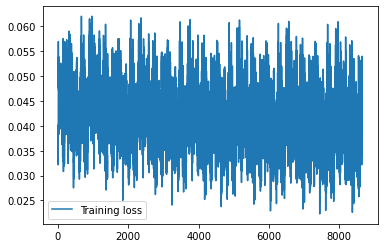

In [50]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

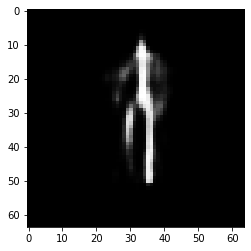

In [53]:
plt.imshow(pred_y[3].detach().cpu().view(64, 64), cmap="gray")

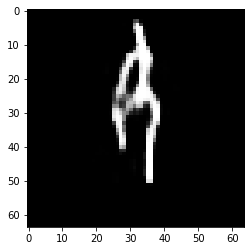

In [54]:
plt.imshow(y[3].cpu().view(64, 64), cmap="gray")

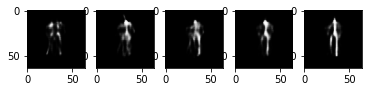

In [56]:
with torch.no_grad():
    img = vae.decoder(torch.squeeze(prediction[3])).detach().cpu()
    for i in range(seq_len):
        plt.subplot(1, 5, i+1)
        plt.imshow(img[i].view(64, 64), cmap="gray")